# DDIM Example (Denoising Diffusion Implicit Model)

### DDIM Paper : https://arxiv.org/pdf/2010.02502.pdf

# Import useful libraries

In [1]:
import cv2
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

2024-01-24 04:13:06.516476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 04:13:07.605683: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/tensorflow/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-01-24 04:13:07.605787: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or director

In [2]:
print("OpenCV version: ", cv2.__version__)
print ("TF Version: ", tf.__version__)

OpenCV version:  4.9.0
TF Version:  2.11.0


# Download and show Data

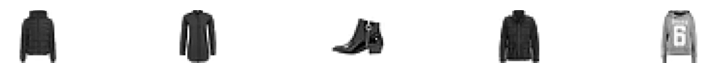

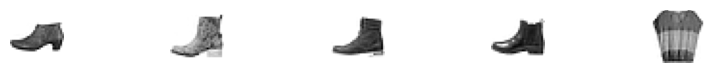

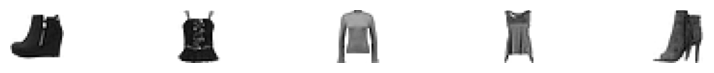

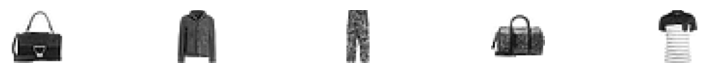

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
for k in range(4):
    plt.figure(figsize=(10, 4))
    for j in range(5):
        i = np.random.randint(0, 10000)
        plt.subplot(550 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
    plt.show()

# Config (HyperParameters for diffusion model setup)

In [4]:
# model related
batch_size=64
epochs=20
embedding_dims=32
embedding_min_frequency=1.0
embedding_max_frequency=1000.0
residual_blocks=2
first_conv_layer_width = fclw = 32
network_widths=[fclw * 1, fclw * 2, fclw * 4, fclw * 8]
has_attention = [False, False, True, True]
norm_groups=8
learning_rate=0.0005
weight_decay=0.0001

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# dataset related
img_size=64
img_channels=1

# Data Preparation

### Data preparation and augmentation utility functions

In [5]:
def preprocess_image(img, size):
    """Resize and Scale images."""
    height, width = tf.shape(img)[0], tf.shape(img)[1]

    # resizing
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, size, antialias=True)

    # scaling to [-1, 1]
    img = (img/127.5) - 1.0
    img = tf.clip_by_value(img, -1.0, 1.0)
    return img

In [6]:
def flip_image(img):
    """flipping image horizontally."""
    img = cv2.flip(img, 1)
    return img

### loading and preparing data for the model

#### Fashion MNIST

In [7]:
(dataset,) = tfds.load(
    "fashion_mnist",
    split=['train'],
    with_info=False,
    shuffle_files=True,
)

2024-01-24 04:13:17.015107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-24 04:13:17.047755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-24 04:13:17.048022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-24 04:13:17.048885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [8]:
def prepare_data(x):
    img = x['image']
    img = preprocess_image(img, size=(img_size, img_size))
    return img

#### Creating training dataset

In [9]:
train_ds = (
    dataset.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .shuffle(batch_size * 2)
    .prefetch(tf.data.AUTOTUNE)
)

# Define Model (UNET)

### define kernel initializer

In [10]:
def get_kernel_initializer(scale):
    scale = max(scale, 1e-10) # avoid zero
    kernel_init = tf.keras.initializers.VarianceScaling(
        scale=scale, mode="fan_avg", distribution="uniform"
    )
    return kernel_init

### unet model building blocks

#### define sinusoidal embedding function

In [11]:
@tf.keras.utils.register_keras_serializable()
def get_sinusoidal_embeddings(x):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = tf.cast(
        2 * math.pi * frequencies,
        dtype="float32",
    )
    embeddings = tf.concat(
        [tf.math.sin(angular_speeds * x), tf.math.cos(angular_speeds * x)],
        axis=3,
    )
    return embeddings

#### Residual UNET block

In [12]:
def residual_unet_block(
    data,
    width,
    attention,
    groups=8,
    activation=tf.keras.activations.swish,
):
    x = data
    if x.shape[3] == width:
        # if dimension same
        residual = x
    else:
        # make dimensions same for skip connection
        residual = tf.keras.layers.Conv2D(
            width,
            kernel_size=1,
            kernel_initializer=get_kernel_initializer(1.0),
        )(x)
    
    # regular Conv block
    x = tf.keras.layers.GroupNormalization(groups=groups)(x)
    x = activation(x)
    x = tf.keras.layers.Conv2D(
        width,
        kernel_size=3,
        padding="same",
        kernel_initializer=get_kernel_initializer(1.0),
    )(x)
    
    # Another Conv Block
    x = tf.keras.layers.GroupNormalization(groups=groups)(x)
    x = activation(x)
    x = tf.keras.layers.Conv2D(
        width,
        kernel_size=3,
        padding="same",
        kernel_initializer=get_kernel_initializer(0.0),
    )(x)
    
    # residual or skip-connection 
    x = tf.keras.layers.Add()([x, residual])

    # add attention layer
    if attention:
        residual = x
        x = tf.keras.layers.GroupNormalization(
            groups=groups,
            center=False,
            scale=False,
        )(x)
        # Multi Headed Self Attention layer
        x = tf.keras.layers.MultiHeadAttention(
            num_heads=4,
            key_dim=width,
            attention_axes=(1, 2),
        )(x, x)
        # residual connection
        x = tf.keras.layers.Add()([residual, x])

    return x

#### downsampling block for UNET

In [13]:
def downsample_block(data, width):
    # Conv block with strides for downsampling
    x = tf.keras.layers.Conv2D(
        width,
        kernel_size=3,
        strides=2,
        padding="same",
        kernel_initializer=get_kernel_initializer(1.0),
    )(data)
    return x

#### up-sampling block for UNET

In [14]:
def upsample_block(data, width, interpolation="nearest"):
    # using upsampling2D layer
    x = tf.keras.layers.UpSampling2D(
        size=2,
        interpolation=interpolation,
    )(data)
    x = tf.keras.layers.Conv2D(
        width,
        kernel_size=3,
        padding="same",
        kernel_initializer=get_kernel_initializer(1.0),
    )(x)
    return x

### build unet model

In [15]:
def build_unet(
    img_size, 
    img_channels,
    first_conv_layer_width,
    network_widths,
    has_attention,
    residual_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation=tf.keras.activations.swish,
):
    img_input = tf.keras.layers.Input(
        shape=(img_size, img_size, img_channels), name="noisy_input_img"
    )
    noise_variances = tf.keras.layers.Input(
        shape=(1, 1, 1), name="noise_variance_input"
    )

    # embedding noise variances, using sinusoidal embedding.
    emb = tf.keras.layers.Lambda(
        get_sinusoidal_embeddings,
        output_shape=(1, 1, 32),
    )(noise_variances)
    emb = tf.keras.layers.UpSampling2D(
        size=img_size,
        interpolation=interpolation,
    )(emb)

    # first conv layer on img
    x = tf.keras.layers.Conv2D(
        first_conv_layer_width,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=get_kernel_initializer(1.0),
    )(img_input)

    # concatenating image features and noise variance embeddings
    x = tf.keras.layers.Concatenate()([x, emb])
    
    # list for skip-connections
    skips = [x]
    
    # Encoder part of our UNET (Downsampling)
    for i in range(len(network_widths)):
        for _ in range(residual_blocks):
            x = residual_unet_block(
                x,
                network_widths[i],
                has_attention[i],
                groups=norm_groups,
                activation=activation,
            )            
            skips.append(x)
        
        if network_widths[i] != network_widths[-1]:
            # if not last block: Downsample
            x = downsample_block(x, network_widths[i])
            skips.append(x)
    
    # Middle Block of UNET with two residual blocks(Bottleneck)
    x = residual_unet_block(
        x,
        width=network_widths[-1],
        attention=True,
        groups=norm_groups,
        activation=activation,
    )
    x = residual_unet_block(
        x,
        width=network_widths[-1],
        attention=True,
        groups=norm_groups,
        activation=activation,
    )
    
    # Decoder part of our UNET (Upsampling)
    for i in reversed(range(len(network_widths))):
        for _ in range(residual_blocks+1):
            # add skip-connection UNET style
            x = tf.keras.layers.Concatenate(
                axis=-1
            )([x, skips.pop()])
            x = residual_unet_block(
                x,
                network_widths[i],
                has_attention[i],
                groups=norm_groups,
                activation=activation,
            )
            # add your attention block here
            
        if i != 0:
            # if not last block: Upsample
            x = upsample_block(
                data=x,
                width=network_widths[i],
                interpolation=interpolation,
            )
    
    # Final Block of UNET
    x = tf.keras.layers.GroupNormalization(groups=norm_groups)(x)
    x = activation(x)
    x = tf.keras.layers.Conv2D(
        img_channels,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=get_kernel_initializer(0.0),
    )(x)
    
    unet_model = tf.keras.models.Model(
        inputs=[img_input, noise_variances],
        outputs=x,
        name="unet_network",
    )
    return unet_model

# Training Utility for our Diffusion Model

In [16]:
class DiffusionModel(tf.keras.Model):
    """Here we define utilities for training.
    
    And, plotting the generated data from model.
    """
    def __init__(
        self,
        img_size,
        img_channels,
        unet_network,
        ema_unet_network,
        ema=0.999,
    ):
        super().__init__()
        self.img_size = img_size
        self.img_channels = img_channels
        self.unet_network = unet_network
        self.ema_unet_network = ema_unet_network
        self.ema = ema

        # Following layer will shift and scale inputs into a distribution 
        # centered around 0 with standard deviation 1.
        self.scaler = tf.keras.layers.Normalization()
        
        
    def get_diffusion_schedule(self, diffusion_times):
        # convert diffusion times to angles
        angle_start = tf.cast(tf.math.acos(max_signal_rate), "float32")
        angle_end = tf.cast(tf.math.acos(min_signal_rate), "float32")
        
        diffusion_angles = angle_start + diffusion_times * (angle_end - angle_start)

        # convert angles to noise and signal rates.
        signal_rates = tf.math.cos(diffusion_angles)
        noise_rates = tf.math.sin(diffusion_angles)
        # sin^2(x) + cos^2(x) = 1. (always)
        
        return noise_rates, signal_rates
    
    def denoise_images(self, noisy_images, noise_rates, signal_rates, training):
        # if evaluating: use the EMA network weights
        if training:
            network = self.unet_network
        else:
            network = self.ema_unet_network
        
        # predict noise using the network
        pred_noises = network(
            [noisy_images, noise_rates**2],
            training=training,
        )

        # calculate image signal using predicted noise
        pred_images = (noisy_images - pred_noises * noise_rates) / signal_rates

        return pred_noises, pred_images
    
    def rescaler(self, images):
        # converting images back to [0, 1] range
        images = self.scaler.mean + images * self.scaler.variance**0.5
        images = tf.clip_by_value(images, 0.0, 1.0)
        return images
 
    def train_step(self, img_batch):
        # retrieve the batch size
        batch_size = tf.shape(img_batch)[0]

        # normalizing inputs: centered at 0, standard deviation = 1
        images = self.scaler(img_batch, training=True)

        # creating noise batch
        noises = tf.random.normal(
            shape=(batch_size, self.img_size, self.img_size, self.img_channels),
        )

        # sampling random uniform diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1),
            minval=0.0,
            maxval=1.0,
        )

        # get noise rate and signal rate values from the scheduler
        noise_rates, signal_rates = self.get_diffusion_schedule(
            diffusion_times=diffusion_times,
        )

        # adding noise to images
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # denoising the noisy images using our unet network
            pred_noises, pred_images = self.denoise_images(
                noisy_images, noise_rates, signal_rates, training=True,
            )

            # calculate loss
            noise_loss = self.loss(noises, pred_noises)
            img_loss = self.loss(images, pred_images)
        
        # fetch the gradients
        gradients = tape.gradient(
            noise_loss,
            self.unet_network.trainable_weights
        )
        
        # updating the weights of the network (optimizer step)
        self.optimizer.apply_gradients(
            zip(gradients, self.unet_network.trainable_weights)
        )
        
        # updating the weights of the ema network
        for new_weight, ema_weight in zip(
            self.unet_network.weights,
            self.ema_unet_network.weights,
        ):
            ema_weight.assign(
                self.ema * ema_weight + (1 - self.ema) * new_weight
            )
        
        # return the loss value
        return {"noise_loss": noise_loss, "img_loss": img_loss}

    # define a funtion to generate images from noise
    def generate_images(self, diffusion_steps, num_images=8):
        # generate a batch of noise images.
        noises = tf.random.normal(
            shape=(num_images, img_size, img_size, img_channels),
            dtype=tf.float32,
        )
        
        step_size = 1.0 / diffusion_steps

        # signal rate of full noise images is
        # assumed to be non-zero (min-signal-rate)
        
        next_noisy_images = noises
        # sample from the model iteratively (for each diffusion step)
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # denoising the current noisy image
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.get_diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise_images(
                noisy_images,
                noise_rates,
                signal_rates,
                training=False,  # evaluation mode
            )
            
            # remix the predicted images with new noise and signal components
            # create a set of new noisy images for the next step
            next_diffusion_times = diffusion_times - step_size
            noise_rates_next, signal_rates_next = self.get_diffusion_schedule(
                next_diffusion_times,
            )
            next_noisy_images = (
                pred_images * signal_rates_next + pred_noises * noise_rates_next
            )

        # rescaling images to expected range
        generated_images = self.rescaler(pred_images)
        # return the final generated samples (after all sampling steps)
        return generated_images
    
    # a function to plot the generated images
    def plot_generated_images(
        self,
        epoch=None,
        logs=None,
        show=True,
        rows=1,
        cols=5,
        diffusion_steps=20,
        figsize=(5, 4),
    ):
        if not show:
            return
        
        # get image size
        img_size=self.img_size
        img_channels=self.img_channels

        # generate images using the diffusion model
        generated_images = self.generate_images(
            num_images=rows*cols,
            diffusion_steps=diffusion_steps,
        )
        
        # plotting images using matplotlib
        _, ax = plt.subplots(rows, cols, figsize=figsize)
        cmap=None
        if img_channels == 1:
            cmap="gray_r"
        for ix, image in enumerate(generated_images):
            if rows == 1:
                ax[ix].imshow(image, cmap=cmap)
                ax[ix].axis("off")
            else:
                ax[ix // cols, ix % cols].imshow(image, cmap=cmap)
                ax[ix // cols, ix % cols].axis("off")
        
        plt.tight_layout()
        plt.show()

# Build the Diffusion Model

In [17]:
# build UNET network
unet_network = build_unet(
    img_size=img_size,
    img_channels=img_channels,
    first_conv_layer_width=first_conv_layer_width,
    network_widths=network_widths,
    has_attention=has_attention,
    residual_blocks=residual_blocks,
    norm_groups=norm_groups,
)

# build similar UNET for storing EMA weights
ema_unet_network = build_unet(
    img_size=img_size,
    img_channels=img_channels,
    first_conv_layer_width=first_conv_layer_width,
    network_widths=network_widths,
    has_attention=has_attention,
    residual_blocks=residual_blocks,
    norm_groups=norm_groups,
)

# initially the weights of both networks should be same
ema_unet_network.set_weights(unet_network.get_weights())

# get final diffusion model with our custom training setup
diffusion_model = DiffusionModel(
    img_size=img_size,
    img_channels=img_channels,
    unet_network=unet_network,
    ema_unet_network=ema_unet_network,
)

# Compling the Diffusion model

In [18]:
diffusion_model.compile(
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        # weight_decay=weight_decay,
    )
)

In [19]:
# calculate mean and variance of training dataset for normalization
diffusion_model.scaler.adapt(train_ds)

# Training Diffusion Model

Epoch 1/20


2024-01-24 04:14:41.985431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900
2024-01-24 04:14:43.603537: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa9dcf36170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-24 04:14:43.603579: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-01-24 04:14:43.610161: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-24 04:14:43.730546: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


937/937 [==============================] - ETA: 0s - noise_loss: 0.1147 - img_loss: 0.2585

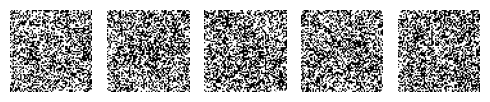

937/937 [==============================] - 317s 270ms/step - noise_loss: 0.1147 - img_loss: 0.2584
Epoch 2/20
937/937 [==============================] - ETA: 0s - noise_loss: 0.0727 - img_loss: 0.1414

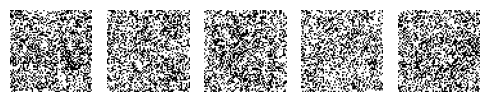

937/937 [==============================] - 252s 269ms/step - noise_loss: 0.0726 - img_loss: 0.1414
Epoch 3/20
937/937 [==============================] - ETA: 0s - noise_loss: 0.0688 - img_loss: 0.1330

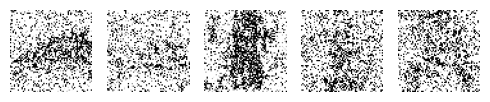

937/937 [==============================] - 252s 269ms/step - noise_loss: 0.0688 - img_loss: 0.1330
Epoch 4/20
937/937 [==============================] - ETA: 0s - noise_loss: 0.0665 - img_loss: 0.1272

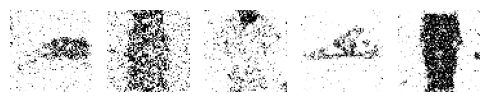

937/937 [==============================] - 252s 269ms/step - noise_loss: 0.0665 - img_loss: 0.1272
Epoch 5/20
937/937 [==============================] - ETA: 0s - noise_loss: 0.0650 - img_loss: 0.1239

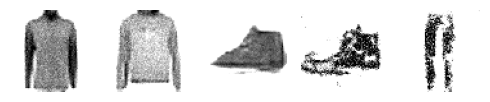

937/937 [==============================] - 252s 268ms/step - noise_loss: 0.0650 - img_loss: 0.1239
Epoch 6/20
937/937 [==============================] - ETA: 0s - noise_loss: 0.0643 - img_loss: 0.1217

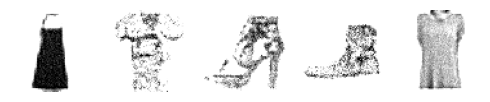

937/937 [==============================] - 252s 269ms/step - noise_loss: 0.0643 - img_loss: 0.1217
Epoch 7/20
937/937 [==============================] - ETA: 0s - noise_loss: 0.0634 - img_loss: 0.1211

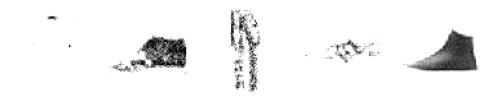

937/937 [==============================] - 252s 269ms/step - noise_loss: 0.0634 - img_loss: 0.1211
Epoch 8/20
937/937 [==============================] - ETA: 0s - noise_loss: 0.0626 - img_loss: 0.1199

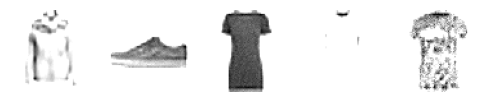

937/937 [==============================] - 252s 269ms/step - noise_loss: 0.0626 - img_loss: 0.1199
Epoch 9/20
759/937 [=======================>......] - ETA: 46s - noise_loss: 0.0621 - img_loss: 0.1182

In [ ]:
diffusion_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_end=diffusion_model.plot_generated_images
    )],
)

# Generating Samples (DDIM)

## Using 1000 Diffusion Steps

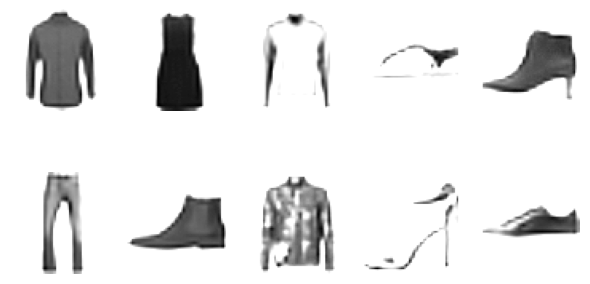

In [21]:
diffusion_model.plot_generated_images(show=True, rows=2, cols=5, diffusion_steps=1000, figsize=(6,4))

## Using 20 Diffusion steps

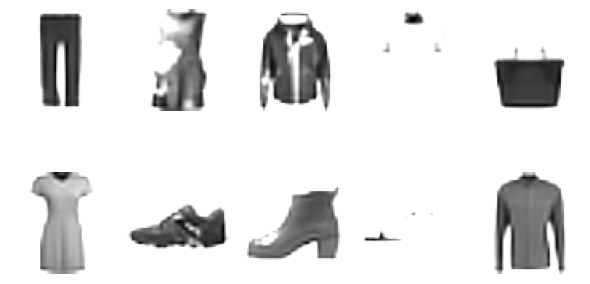

In [22]:
diffusion_model.plot_generated_images(show=True, rows=2, cols=5, diffusion_steps=20, figsize=(6,4))

## Using 5 Diffusion Steps

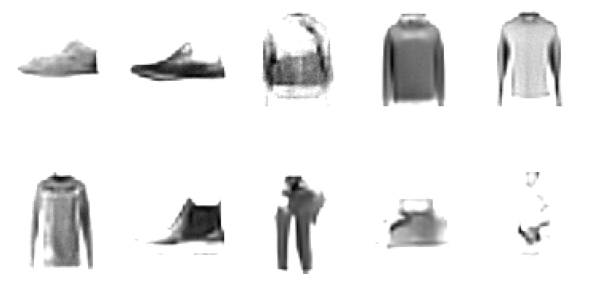

In [23]:
diffusion_model.plot_generated_images(show=True, rows=2, cols=5, diffusion_steps=5, figsize=(6,4))

# Loss chart

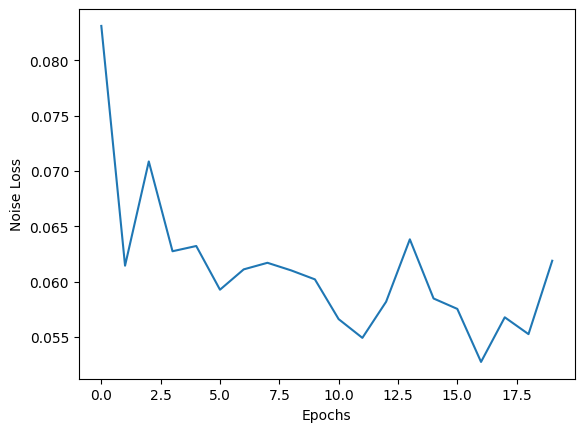

In [24]:
plt.plot(diffusion_model.history.history['noise_loss'])
plt.ylabel("Noise Loss")
plt.xlabel("Epochs")
plt.show()

# Network Summary

In [25]:
unet_network.summary()

Model: "unet_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise_variance_input (InputLay  [(None, 1, 1, 1)]   0           []                               
 er)                                                                                              
                                                                                                  
 noisy_input_img (InputLayer)   [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 1, 1, 32)     0           ['noise_variance_input[0][0]']   
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['noisy_input_img[0][0